## The following notebook contains statistical analysis and the code for obtaining Figure 6C

#### Datasets used
- PDB GFAP HT
- HDX data

#### Workflow
- Import and parse PDB structure predicted by AlphaFold for the dimer
- Extract pLDDT scores per amino acid residue
- Scale relative fractional uptake values in artificial CSF vs KPBS

#### Outpoot
- Combined pLDDT - HDX plot

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
from Bio.PDB import PDBParser
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

### Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
structure_path = os.path.dirname(os.getcwd()) + '/structures'
figure_path = os.path.dirname(os.getcwd()) + '/figures'

In [3]:
# Load the PDB file
pdb_parser = PDBParser()
pdb_file_path = structure_path + "/GFAP_HT_Dimer.pdb"

# Load the PDB file
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("protein", pdb_file_path)

In [4]:
# Create a DataFrame to store the data
data = []

# Iterate through the structure to extract information
for model in structure:
    for chain in model:
        chain_id = chain.id
        for residue in chain:
            # Extract residue information
            amino_acid_number = residue.id[1]
            amino_acid_type = residue.get_resname()
            pLDDT_score = residue['CA'].get_bfactor()
            
            # Append the information to the data list
            data.append([amino_acid_number, amino_acid_type, chain_id, pLDDT_score])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=["Number", "Amino acid", "Chain", "pLDDT"])

# Now, the DataFrame 'df' contains the desired information
#df['pLDDT'].describe()
df

,Number,Amino acid,Chain,pLDDT
0,1,ALA,A,37.62
1,2,GLY,A,39.38
2,3,PHE,A,48.22
3,4,LYS,A,50.94
4,5,GLU,A,54.41
...,...,...,...,...
643,320,ILE,B,42.03
644,321,PRO,B,39.66
645,322,VAL,B,37.59
646,323,GLN,B,34.66


In [5]:
# Select chain A
final_df = df[df['Chain'] == 'A'] 

# Combine XDX data with pLDDT scores
hdx = data_path + '/feature_overview.txt' 
hdx = pd.read_csv(hdx, sep=',')
updake = list(hdx['uptake'])
final_df['Uptake'] = updake

In [6]:
final_df

,Number,Amino acid,Chain,pLDDT,Uptake
0,1,ALA,A,37.62,0.068625
1,2,GLY,A,39.38,0.008280
2,3,PHE,A,48.22,0.008280
3,4,LYS,A,50.94,0.008280
4,5,GLU,A,54.41,0.008280
...,...,...,...,...,...
319,320,ILE,A,41.56,0.087550
320,321,PRO,A,40.06,0.087550
321,322,VAL,A,36.59,0.087550
322,323,GLN,A,33.34,0.087550


In [7]:
final_df['pLDDT'].describe()

count    324.000000
mean      75.555802
std       14.816780
min       26.690000
25%       66.497500
50%       78.815000
75%       87.640000
max       94.120000
Name: pLDDT, dtype: float64

In [8]:
final_df['Uptake'].describe()

count    315.000000
mean       0.440715
std        0.235396
min        0.000000
25%        0.232630
50%        0.441046
75%        0.630982
max        1.000000
Name: Uptake, dtype: float64

In [9]:
# Min-Max Scaling to [0, 100]
min_value = 0
max_value = 100
final_df['Uptake_scaled'] = (final_df['Uptake'] - final_df['Uptake'].min()) / (final_df['Uptake'].max() - final_df['Uptake'].min()) * (max_value - min_value) + min_value

In [10]:
final_df

,Number,Amino acid,Chain,pLDDT,Uptake,Uptake_scaled
0,1,ALA,A,37.62,0.068625,6.862473
1,2,GLY,A,39.38,0.008280,0.827973
2,3,PHE,A,48.22,0.008280,0.827973
3,4,LYS,A,50.94,0.008280,0.827973
4,5,GLU,A,54.41,0.008280,0.827973
...,...,...,...,...,...,...
319,320,ILE,A,41.56,0.087550,8.754983
320,321,PRO,A,40.06,0.087550,8.754983
321,322,VAL,A,36.59,0.087550,8.754983
322,323,GLN,A,33.34,0.087550,8.754983


In [11]:
final_df['Uptake_scaled'].describe()

count    315.000000
mean      44.071461
std       23.539642
min        0.000000
25%       23.263015
50%       44.104588
75%       63.098233
max      100.000000
Name: Uptake_scaled, dtype: float64

In [12]:
final_df['Number'] = final_df['Number'] + 59

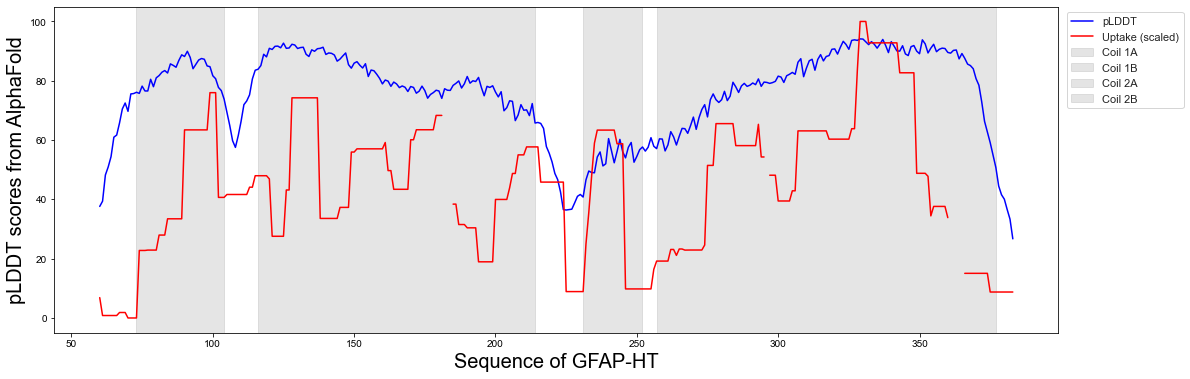

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.set(font_scale=1)
sns.set_style(style="white")

# Convert DataFrame columns to NumPy arrays
amino_acid_number = final_df['Number'].to_numpy()
pLDDT = final_df['pLDDT'].to_numpy()
uptake_scaled = final_df['Uptake_scaled'].to_numpy()

# Plot the pLDDT scores
plt.plot(amino_acid_number, pLDDT, label='pLDDT', color='blue')
plt.plot(amino_acid_number, uptake_scaled, label='Uptake (scaled)', color='red')

# Define the start and end positions for the Coil regions
coil_regions = [(73, 104), (116, 214), (231, 252), (257, 377)]

# Highlight the Coil regions using axvspan and label them
coil_regions = [(73, 104, 'Coil 1A'), (116, 214, 'Coil 1B'), (231, 252, 'Coil 2A'), (257, 377, 'Coil 2B')]
for start, end, label in coil_regions:
    plt.axvspan(start, end, alpha=0.2, color='gray', label=label)

# Add labels and a custom legend
plt.xlabel('Sequence of GFAP-HT', size=20)
plt.ylabel('pLDDT scores from AlphaFold', size=20)
plt.title('')
plt.legend(bbox_to_anchor=(1.13, 1), loc="upper right")

# Show the plot
plt.show()
#fig.savefig(figure_path + "/pLDDT_HDX.png", dpi=600, bbox_inches='tight')